## Regression of UK Exports Over Time

Data downloaded from the Office for National Statistics:
https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/lqad/mret

In [35]:
import pandas as pd
import statsmodels as sm
df = pd.read_csv('series-230425 (1).csv') # Read ONS trade data
df = df.drop(list(range(0,147))).reset_index(drop=True) # Get rid of header & additional info and reset index.
df.rename(columns={df.columns[0]: 'date', df.columns[1]: 'exports'}, inplace=True) # Re-name columns for simplicity
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

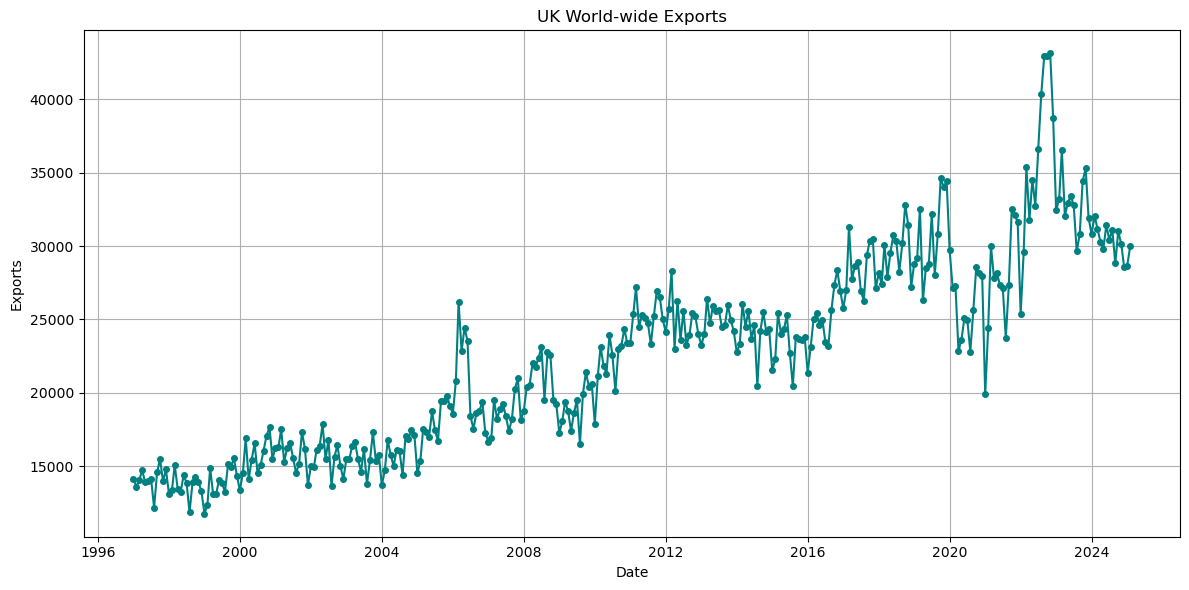

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df['date'] = pd.to_datetime(df['date'], format='%Y %b') # Make 'date' column datetime type

plt.figure(figsize=(12, 6)) # Create plot
plt.plot(df['date'], df['exports'], marker='o', markersize=4,linestyle='-', color='teal')
plt.title('UK World-wide Exports')
plt.xlabel('Date')
plt.ylabel('Exports')
plt.grid(True)
plt.tight_layout()
plt.show()  

In [26]:
# Split data for training & testing
# Trained on historical data; Tested on past year (Mar 2024 - Feb 2025)

train_size = 326
test_size = 12

Y_train = df.iloc[:train_size, 1]  # First 326 points
Y_test = df.iloc[-test_size:, 1]  # Last 12 points
X_train = df.iloc[:train_size, 0]  # First 326 points
X_test = df.iloc[-test_size:, 0]  # Last 12 points

## S-ARIMA Approach:

Seasonal Auto-Regressive Integrated Moving Average (S-ARIMA) models are a common modelling technique for time series data. The model allows us to express future values in terms of past values as well as modelling trend, stochasticity and seasonality. 

As our exports data is monthly, we can most likely assume that our order of seasonality should be every 12 months.

The trend of our data also seems close to linear (a polynomial of order 1). This means that we can choose integration of order 1 for our model.

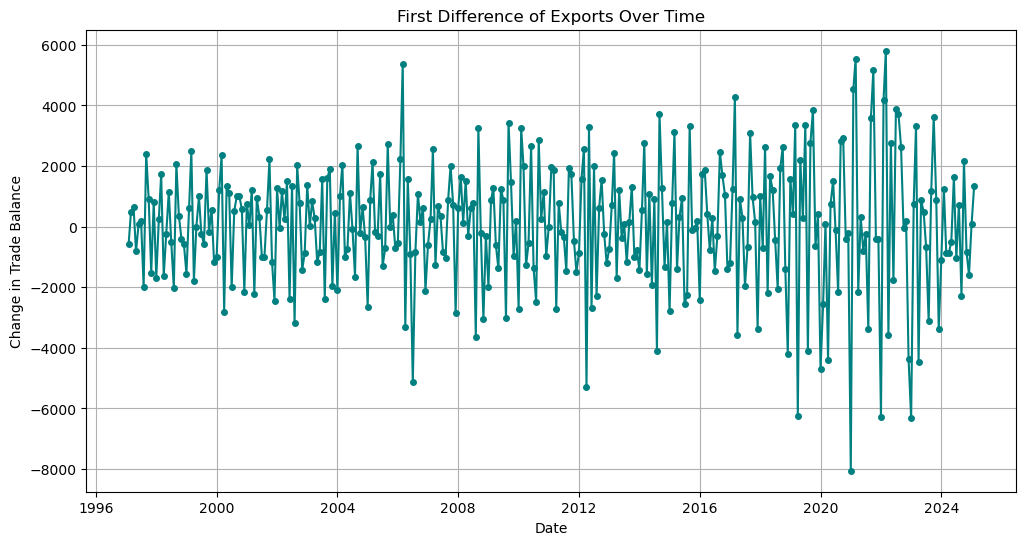

ADF Statistic: -5.74977981258532
p-value: 6.003841841406085e-07


In [17]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['exports'].diff(), marker='o', markersize =4, linestyle='-', color='teal')
plt.xlabel("Date")
plt.ylabel("Change in Trade Balance")
plt.title("First Difference of Exports Over Time")
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller

# Make sure the tradebalance column is numeric
df['exports'] = pd.to_numeric(df['exports'], errors='coerce')

# Take first difference & drop missing values (optional but useful before ADF)
diff_series = df['exports'].diff().dropna()

# Perform Augmented Dickey-Fuller test
result = adfuller(diff_series)

# Print the test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])


After first-differencing, exports seem stationary.

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model
sarima = SARIMAX(Y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = sarima.fit()
model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            exports   No. Observations:                  326
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2739.611
Date:                            Wed, 23 Apr 2025   AIC                           5489.222
Time:                                    16:52:21   BIC                           5507.953
Sample:                                         0   HQIC                          5496.707
                                            - 326                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0493      0.193     -0.256      0.798      -0.428       0.329
ma.L1         -0.1793      0.195     -0.922      0.357      -0.561       0.202
ar.S.L12       0.2126      0.059      3.603      0.000       0.097       0.328
ma.S.L12      -0.8648      0.042    -20.426      0.000      -0.948      -0.782
sigma2      2.251e+06   1.29e+05     17.492      0.000       2e+06     2.5e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                86.99
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(3033.339383994837, 0.0, 0.9606611032174844, 17.819644053151727)


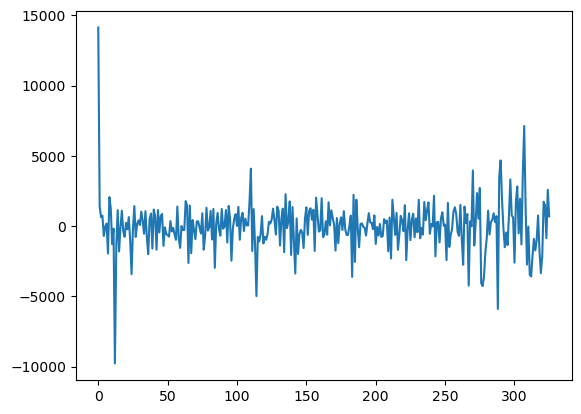

In [37]:
residuals = results.resid

# Perform the Jarque-Bera test
jb_test = sm.stats.stattools.jarque_bera(residuals)

# Print the results
print(jb_test)

plt.plot(residuals)

This has a few problems as 